In [1]:
import collections
import numpy as np
import pandas as pd
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
import string
puncs = string.punctuation.replace('*', '').replace('#', '')
table = str.maketrans('', '', puncs)
import re
# from nltk.stem.porter import PorterStemmer
# porter = PorterStemmer()

import torch
import torch.nn as nn
!pip install transformers
from transformers import BertTokenizer, BertModel
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')
from transformers import BertForSequenceClassification
bertseq = BertForSequenceClassification.from_pretrained('bert-base-uncased')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
     |████████████████████████████████| 1.3MB 10.7MB/s 
     |████████████████████████████████| 2.9MB 22.2MB/s 
     |████████████████████████████████| 1.1MB 44.9MB/s 
     |████████████████████████████████| 890kB 46.7MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=3de9319e286ab97055bc9ce2d71d8a07391b5bb9490fdf05f8a13c4c75e64545
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [2]:
# string.punctuation.replace('*', '')

In [3]:
def checks(w):
    if w in stop_words: return False
    if re.search('[a-zA-Z]', w) and '*' in w: return True
    if not w.isalpha(): return False
    if len(w) == 1 and w not in ['a', 'i', 'o', 'u']: return False
    return True

In [4]:
def getWordCounts(texts, scores, word_tokens):
    l = len(texts)
    wordCounts = {}
    for i in range(l):
        if i % 10000 == 0: print(i)
        text, score = texts[i], scores[i]
        wtoks = word_tokens[i]
        for w in wtoks:
            w = w.lower()
            w = w.translate(table)
            if not checks(w): continue
            wordCounts[w] = wordCounts.get(w, 0) + 1
    return wordCounts

In [5]:
def getWordSentences(texts, word_tokens):
    l = len(texts)
    wordSentences = collections.defaultdict(list)
    for i in range(l):
        if i % 10000 == 0: print(i)
        text = texts[i]
        text = text.lower()
        wtoks = word_tokens[i]
        for w in wtoks:
            w = w.lower()
            w = w.translate(table)
            # w = porter.stem(w)
            if not checks(w): continue
            wordSentences[w].append(text)
    return wordSentences

In [6]:
def getSortedWordScores(wordCounts, asc=False):
    rows_list = []
    for i,w in enumerate(wordCounts):
        dic = {'Word': w, 'Count': wordCounts[w]}
        rows_list.append(dic)
        
    wordScores = pd.DataFrame(rows_list, columns=['Word', 'Count'])
    
    return wordScores

In [7]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
path = '/content/drive/My Drive/DetoxBert/'

Mounted at /content/drive


In [8]:
rows = []
with open(path+'toxic.tsv', 'r') as f:
  lines = f.readlines()
  columns = lines[0].split('\t')
  num_cols = len(columns)
  lines = lines[1:]
  for line in lines:
    fields = line.split('\t')
    if len(fields) > num_cols:
      fields = [' '.join(fields[:-num_cols])] + fields[-num_cols:]
    elif len(fields) < num_cols:      
      for i in range(num_cols - len(fields)):
        fields.append('0')
    rows.append(fields)

df = pd.DataFrame(np.array(rows), columns=columns)


In [9]:

# df = pd.read_csv(path+'toxic_fixed.tsv', sep='\t', encoding='utf-8')
print('done: read file')
# only check toxicity values, todo: check others as well

# df = df[['Text', 'Tox']]
df = df[['Text', 'Sev_Tox']]

df.columns = ['Text', 'Score']
df.Score = df.Score.astype(float)
df = df.fillna(0)
toxic_df = df[df['Score'] >= 0.5]
nontox_df = df[df['Score'] < 0.5]
print('done: got toxic data >=0.5')

done: read file
done: got toxic data >=0.5


In [10]:
toxic_df[:3]['Text'].to_numpy()

array(['That violence is both promoted by the government—one parliamentarian has said if he had a lesbian daughter, he would hang her—and carried out by private citizens with government complicity.',
       'In the latest incident, a car bomb exploded at a petrol station in the government-held Damascus suburb of Barzeh, killing 11 people, including civilians, and injuring 40 more, according to both government and opposition reports.',
       'Sebastopol’s local newspaper reports that seven of the 26 people murdered in Sonoma County since 2013 died during marijuana deals.'],
      dtype=object)

In [11]:
# df = pd.read_csv(path+'toxic.tsv', sep='\t+', encoding='utf-8')

pd.set_option('display.max_colwidth', None)
te = toxic_df[toxic_df['Text'].str.contains('If I fought Rafael dos Anjos')]['Text']
te

56112    "If I fought Rafael dos Anjos, if he didn't pussy out of that last one and showed up, the shots I cracked Nate with in the first eight minutes of that [fight] would've KO'd Rafael dos Anjos stiff.
Name: Text, dtype: object

In [12]:
texts = df['Text'].to_numpy()
scores = df['Score'].to_numpy()
# word_tokens = list(map(word_tokenize, texts))
encoded_texts = list(map(tokenizer.encode, texts))
word_tokens = [list([tokenizer.convert_ids_to_tokens(i) for i in encoded_text[1:-1]]) for encoded_text in encoded_texts]

wcAll = getWordCounts(texts, scores, word_tokens)
wsentAll = getWordSentences(texts, word_tokens)

0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000


In [13]:
# t = "An impatient commuter probably regretted telling a man to 'f**k himself' on a busy train."
# print(t)
print(encoded_texts[0])
print(word_tokens[0])

[101, 7897, 5994, 1996, 16728, 2003, 1996, 2708, 12731, 14277, 14778, 2005, 1996, 3827, 1521, 1055, 3471, 1010, 2429, 2000, 1037, 3522, 3189, 2013, 1996, 2569, 7742, 2236, 2005, 7041, 8735, 1517, 1037, 7740, 2135, 1011, 16714, 3422, 16168, 4034, 1012, 102]
['corruption', 'involving', 'the', 'contractors', 'is', 'the', 'chief', 'cu', '##lp', '##rit', 'for', 'the', 'prison', '’', 's', 'problems', ',', 'according', 'to', 'a', 'recent', 'report', 'from', 'the', 'special', 'inspector', 'general', 'for', 'afghanistan', 'reconstruction', '—', 'a', 'congressional', '##ly', '-', 'mandated', 'watch', '##dog', 'agency', '.']


In [14]:
texts = toxic_df['Text'].to_numpy()
scores = toxic_df['Score'].to_numpy()
# word_tokens = list(map(word_tokenize, texts))
encoded_texts = list(map(tokenizer.encode, texts))
word_tokens = [list([tokenizer.convert_ids_to_tokens(i) for i in encoded_text[1:-1]]) for encoded_text in encoded_texts]

wcTox = getWordCounts(texts, scores, word_tokens)
wsentTox = getWordSentences(texts, word_tokens)

0
10000
20000
30000
0
10000
20000
30000


In [15]:
texts = nontox_df['Text'].to_numpy()
scores = nontox_df['Score'].to_numpy()
# word_tokens = list(map(word_tokenize, texts))
encoded_texts = list(map(tokenizer.encode, texts))
word_tokens = [list([tokenizer.convert_ids_to_tokens(i) for i in encoded_text[1:-1]]) for encoded_text in encoded_texts]

wcNT = getWordCounts(texts, scores, word_tokens)
wsentNT = getWordSentences(texts, word_tokens)

0
10000
20000
30000
40000
50000
60000
0
10000
20000
30000
40000
50000
60000


In [16]:
# wcAll, wcTox, wcNT = wcAll_, wcTox_, wcNT_
# wcAll, wcTox, wcNT = {}, {}, {}

In [17]:
print(len(wcAll))
print(len(wcTox))
print(len(wcNT))

20642
17961
20163


In [18]:
wordScoresAll = getSortedWordScores(wcAll)

In [19]:
wordScoresTox = getSortedWordScores(wcTox)

In [20]:
wordScoresNT = getSortedWordScores(wcNT, asc=True)

In [21]:
print('All\n', wordScoresAll.head())
print('Toxic\n', wordScoresTox.head())
print('NonToxic\n', wordScoresNT.head())

All
           Word  Count
0   corruption    121
1    involving     85
2  contractors     15
3        chief    332
4           cu    413
Toxic
          Word  Count
0    violence    129
1    promoted     13
2  government    234
3         one   2486
4  parliament     21
NonToxic
           Word  Count
0   corruption    106
1    involving     69
2  contractors     13
3        chief    266
4           cu    174


In [22]:
sAll, sTox, sNT = wordScoresAll, wordScoresTox, wordScoresNT

In [23]:
sAll[sAll['Word'] == 'like'], sTox[sTox['Word'] == 'like'], sNT[sNT['Word'] == 'like']

(     Word  Count
 100  like   5731,      Word  Count
 494  like   2712,      Word  Count
 100  like   3019)

In [24]:
from functools import reduce

dfs = [sAll, sTox, sNT]
df_merged = reduce(lambda left,right: pd.merge(left,right,on='Word'), dfs)

In [25]:
df_merged.columns = ['Word', 'Count_All', 'Count_Tox', 'Count_NT']
df_merged.head()

,Word,Count_All,Count_Tox,Count_NT
0,corruption,121,15,106
1,involving,85,16,69
2,contractors,15,2,13
3,chief,332,66,266
4,cu,413,239,174


In [26]:
df_merged['Tox_percent'] = df_merged.apply (lambda row: row['Count_Tox']/(row['Count_All']), axis=1)

In [27]:
df_merged[df_merged['Word'] == 'fuck']

,Word,Count_All,Count_Tox,Count_NT,Tox_percent
16828,fuck,1738,1693,45,0.974108


In [28]:
MINFREQ = 3
df_merged_minfreq = df_merged[(df_merged['Count_All'] > MINFREQ)]

In [29]:
# highTox = df_merged_minfreq.sort_values(["Count_All", "Tox_percent"], ascending = [False, False])

In [30]:
# highTox = df_merged_minfreq.sort_values(["Count_NT", "Count_Tox"], ascending = [True, False])
highTox = df_merged_minfreq.sort_values("Tox_percent", ascending = False)
len(highTox)

16514

In [31]:
highTox[:20]

,Word,Count_All,Count_Tox,Count_NT,Tox_percent
16215,whore,256,252,4,0.984375
10602,ck,300,295,5,0.983333
6559,pussy,315,307,8,0.974603
16828,fuck,1738,1693,45,0.974108
17357,asshole,514,498,16,0.968872
17244,bitch,920,889,31,0.966304
17044,fucking,1524,1471,53,0.965223
16219,fucked,300,289,11,0.963333
16714,penis,1534,1438,96,0.937419
17414,protruding,11,10,1,0.909091


In [32]:
ht = highTox[:]

In [33]:
ht[ht['Word'] == 'damn']

,Word,Count_All,Count_Tox,Count_NT,Tox_percent
9051,damn,763,464,299,0.608126


In [34]:
toxword = ht['Word'][:1]
toxsents = wsentTox['pussy'][:20]
for i, s in enumerate(toxsents):
  if '\t' in s:
    print(i)
    print(s)
    print()

In [35]:
# todo: Compute PMI

In [36]:
# bertseq

In [37]:
bert_model.embeddings

BertEmbeddings(
  (word_embeddings): Embedding(30522, 768, padding_idx=0)
  (position_embeddings): Embedding(512, 768)
  (token_type_embeddings): Embedding(2, 768)
  (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
  (dropout): Dropout(p=0.1, inplace=False)
)

In [38]:
bert_model.encoder.layer[0]

BertLayer(
  (attention): BertAttention(
    (self): BertSelfAttention(
      (query): Linear(in_features=768, out_features=768, bias=True)
      (key): Linear(in_features=768, out_features=768, bias=True)
      (value): Linear(in_features=768, out_features=768, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (output): BertSelfOutput(
      (dense): Linear(in_features=768, out_features=768, bias=True)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
  )
  (intermediate): BertIntermediate(
    (dense): Linear(in_features=768, out_features=3072, bias=True)
  )
  (output): BertOutput(
    (dense): Linear(in_features=3072, out_features=768, bias=True)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
)

In [56]:
import sklearn as sl
from sklearn.preprocessing import StandardScaler as ss
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def plotVariance(y, title=""):
  x = range(len(y))
  plt.plot(x, y)
  plt.title(title)
  plt.show()
  plt.savefig(title)


# Computes PCs of difference vector
def getPrincipalComponents(D, num_comp=None):
  print(D.shape)
  pca = PCA(n_components=num_comp, svd_solver="auto")
  X = D[0].cpu().detach().numpy()
  pca.fit(X)
  exp_var = pca.explained_variance_ratio_
  return torch.Tensor(np.array(pca.components_)), exp_var

In [40]:
class LayerBERT(nn.Module):

    def __init__(self):
        super(LayerBERT, self).__init__()
        self.bert_layer0 = bert_model.embeddings
        self.bert_layers = bert_model.encoder.layer

    def forward(self, layer_num, inp_ids, attn_masks=None):
        if layer_num == 0:
            return self.bert_layer0(inp_ids, attn_masks)  # both are batch_size x seq_len
        elif 1 <= layer_num <= 12:
            return self.bert_layers[layer_num - 1](inp_ids)

layerBert = LayerBERT()
layerBert = layerBert.cuda()


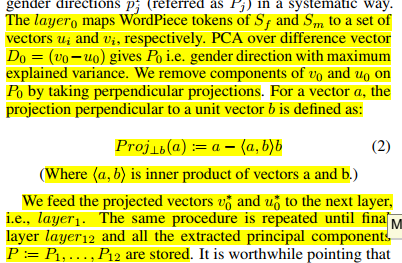

In [41]:
def projection(a, b):
  inner = torch.mm(a, b.T)
  res = a - torch.mm(inner, b)
  return res

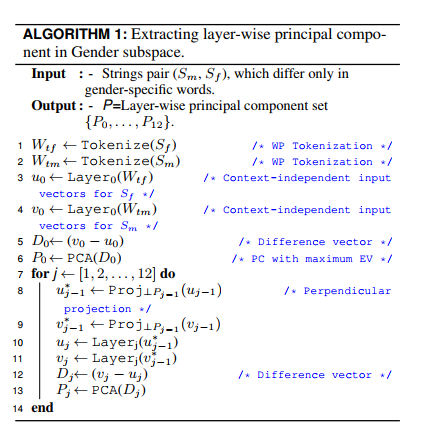

In [42]:
a, b = torch.rand(2,3), torch.rand(2,3)
print(a)
print(b)
print(a.shape, b.shape)
a - b

tensor([[0.1941, 0.0068, 0.3582],
        [0.9277, 0.5767, 0.5947]])
tensor([[0.7258, 0.2525, 0.4246],
        [0.7336, 0.4861, 0.1980]])
torch.Size([2, 3]) torch.Size([2, 3])


tensor([[-0.5316, -0.2457, -0.0664],
        [ 0.1941,  0.0906,  0.3967]])

In [ ]:
# this algorithm takes in toxic sentence and corresponsing nontoxic sentence
# and returns layer wise PC set {P_0, ..., P_12}
def run_bert_algorithm(S_t, S_nt, model, debias=True):
    # inputs are encoded sentences
    W_t, W_nt = S_t, S_nt

    inp_ids_t, attn_masks_t = W_t['input_ids'], W_t['attention_mask']
    inp_ids_nt, attn_masks_nt = W_nt['input_ids'], W_nt['attention_mask']

    u, v, D, PCs, ev = [None] * 13, [None] * 13, [None] * 13, [None] * 13, [None] * 13
    inp_t = inp_ids_t.cuda()
    atn_t = attn_masks_t.cuda()
    inp_nt = inp_ids_nt.cuda()
    atn_nt = attn_masks_nt.cuda()

    u[0] = model(0, inp_t, atn_t)
    v[0] = model(0, inp_nt, atn_nt)
    D[0] = u[0] - v[0]  # todo: check dim, torch. ?

    PCs[0], ev[0] = getPrincipalComponents(D[0])
    # PCs[0] = torch.Tensor(PCs[0]).unsqueeze(dim=0).cuda()
    PCs[0] = PCs[0].cuda()

    for j in range(1, 13):
        # print("BERT Layer j =", j)
        if debias:
          uproj = projection(u[j - 1][0], PCs[j - 1])
          vproj = projection(v[j - 1][0], PCs[j - 1])
        else:
          uproj = u[j-1][0]
          vproj = v[j-1][0]

        uproj = uproj.unsqueeze(dim=0).cuda()
        vproj = vproj.unsqueeze(dim=0).cuda()
        u[j] = model(j, uproj)[0]
        v[j] = model(j, vproj)[0]
        
        D[j] = u[j] - v[j]  # todo: check dim, torch. ?
        PCs[j], ev[j] = getPrincipalComponents(D[j])
        PCs[j] = PCs[j].cuda()

        # print('PCs[j]', PCs[j].shape)

    return PCs, ev


**Debiasing BERT**

In [44]:
num_words = 10
num_sents = 10

In [57]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

toxic_words = ht['Word'][:num_words]

ev = [0]*13
count = 0
# find toxic words and their sentences
for word in toxic_words:
  
  sents = wsentTox[word][:num_sents]
  print('word', word, 'num_sent', num_sents)
  sflag = False

  for sent in sents:
    if count % 10 == 0: print(count)
    encoded_text = tokenizer.encode_plus(
        sent, add_special_tokens=True, truncation=True,
        max_length=256, padding='max_length',
        return_attention_mask=True,
        return_tensors='pt')
    tox, attn_masks = encoded_text['input_ids'], encoded_text['attention_mask']
    ntox = tox.clone()
    tokens = list([tokenizer.convert_ids_to_tokens(i) for i in ntox][0])
    try:
      idx = tokens.index(word)
    except:
      print('PROBLEM!')
      print(sent)
      continue
      # sflag = True
      # break
    
    ntox[0][idx] = 0

    encoded_T = {
        "input_ids": tox,
        "attention_mask": attn_masks
    }
    encoded_NT = {
        "input_ids": ntox,
        "attention_mask": attn_masks
    }
    principal_components, exp_variance = run_bert_algorithm(encoded_T, encoded_NT, layerBert, debias=True)
    if count % 10 == 0: print('exp_var', np.array(exp_variance).shape)
    for i in range(13):
      ev[i] += exp_variance[i]
    count += 1
  
  if sflag:
    break

print(count)
# print('ev[0]', ev[0])
# todo: Use BERTForSentenceClassification then check the classifier hidden output

# a = num_sent x 768
# b = 2 x 768 PCs
# inner = a . bT -> num_sent x 2
# inner . b -> num_sent x 768




word whore num_sent 10
0
torch.Size([1, 256, 768])
torch.Size([1, 256, 768])
torch.Size([1, 256, 768])
torch.Size([1, 256, 768])
torch.Size([1, 256, 768])
torch.Size([1, 256, 768])
torch.Size([1, 256, 768])
torch.Size([1, 256, 768])
torch.Size([1, 256, 768])
torch.Size([1, 256, 768])
torch.Size([1, 256, 768])
torch.Size([1, 256, 768])
torch.Size([1, 256, 768])
exp_var (13, 256)
torch.Size([1, 256, 768])
torch.Size([1, 256, 768])
torch.Size([1, 256, 768])
torch.Size([1, 256, 768])
torch.Size([1, 256, 768])
torch.Size([1, 256, 768])
torch.Size([1, 256, 768])
torch.Size([1, 256, 768])
torch.Size([1, 256, 768])
torch.Size([1, 256, 768])
torch.Size([1, 256, 768])
torch.Size([1, 256, 768])
torch.Size([1, 256, 768])
torch.Size([1, 256, 768])
torch.Size([1, 256, 768])
torch.Size([1, 256, 768])
torch.Size([1, 256, 768])
torch.Size([1, 256, 768])
torch.Size([1, 256, 768])
torch.Size([1, 256, 768])
torch.Size([1, 256, 768])
torch.Size([1, 256, 768])
torch.Size([1, 256, 768])
torch.Size([1, 256, 7

KeyboardInterrupt: ignored

In [46]:
# average and percentage
ev = [e/count*100 for e in ev]
ev1 = ev
# for i, e in enumerate(ev1):
#   print(i)
#   plotVariance(e[:30])

First PCs [100.0, 16.664305, 3.2204165, 1.6506686, 1.5292506, 1.6809036, 2.2854211, 1.804318, 1.5084901, 1.7115537, 2.2025723, 8.683898, 1.920198]


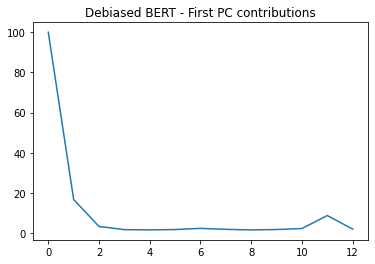

Second PCs [8.2640454e-13, 4.872872, 1.7010942, 1.3906151, 1.2556964, 1.3359292, 1.4048938, 1.2969484, 1.243423, 1.2572174, 1.4299388, 2.8292646, 1.4840128]


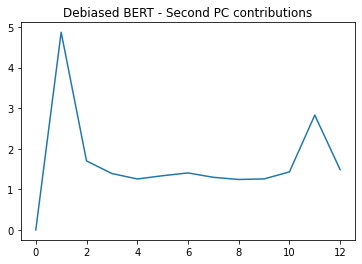

Third PCs [3.5527137e-13, 2.580907, 1.5077897, 1.2715862, 1.175367, 1.2134389, 1.2250774, 1.1942662, 1.1567006, 1.1461089, 1.2134941, 2.256406, 1.341799]


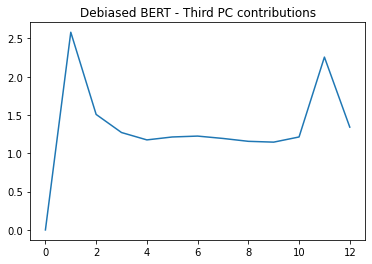

<Figure size 432x288 with 0 Axes>

In [47]:
first_pcs = [f[0] for f in ev1]
print('First PCs', first_pcs)
plotVariance(first_pcs, title='Debiased BERT - First PC contributions')

second_pcs = [f[1] for f in ev1]
print('Second PCs', second_pcs)
plotVariance(second_pcs, title='Debiased BERT - Second PC contributions')

third_pcs = [f[2] for f in ev1]
print('Third PCs', third_pcs)
plotVariance(third_pcs, title='Debiased BERT - Third PC contributions')

**Normal BERT**

In [48]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

toxic_words = ht['Word'][:num_words]

ev = [0]*13
count = 0
# find toxic words and their sentences
for word in toxic_words:
  
  sents = wsentTox[word][:num_sents]
  print('word', 'num_sent', len(sents))
  sflag = False
  for sent in sents:
    if count % 10 == 0: print(count)
    encoded_text = tokenizer.encode_plus(
        sent, add_special_tokens=True, truncation=True,
        max_length=256, padding='max_length',
        return_attention_mask=True,
        return_tensors='pt')
    tox, attn_masks = encoded_text['input_ids'], encoded_text['attention_mask']
    ntox = tox.clone()
    tokens = list([tokenizer.convert_ids_to_tokens(i) for i in ntox][0])
    try:
      idx = tokens.index(word)
    except:
      print('PROBLEM!')
      print(sent)
      continue
      # sflag = True
      # break

    ntox[0][idx] = 0

    encoded_T = {
        "input_ids": tox,
        "attention_mask": attn_masks
    }
    encoded_NT = {
        "input_ids": ntox,
        "attention_mask": attn_masks
    }
    principal_components, exp_variance = run_bert_algorithm(encoded_T, encoded_NT, layerBert, debias=False)

    for i in range(13):
      ev[i] += exp_variance[i]
    count += 1

  if sflag:
    break
print(count)
# print('ev[0]', ev[0])
# todo: Use BERTForSentenceClassification then check the classifier hidden output

# a = num_sent x 768
# b = 2 x 768 PCs
# inner = a . bT -> num_sent x 2
# inner . b -> num_sent x 768




word num_sent 10
0
word num_sent 10
10
word num_sent 10
20
word num_sent 10
30
word num_sent 10
40
word num_sent 10
50
word num_sent 10
60
word num_sent 10
70
word num_sent 10
80
word num_sent 10
90
100


In [49]:
# for i, e in enumerate(ev2):
#   print(i)
#   plotVariance(e[:30])

First PCs [100.0, 95.90289, 92.64047, 85.98039, 78.738716, 72.203766, 65.12186, 62.055866, 59.318584, 59.55841, 58.60945, 58.619534, 49.985893]


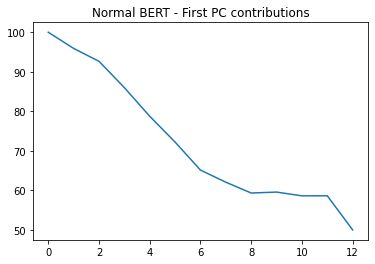

Second PCs [8.2640454e-13, 2.0574522, 3.2137442, 6.8487763, 10.142096, 13.056733, 15.789739, 16.679626, 17.376616, 16.62317, 16.79904, 16.179943, 18.2871]


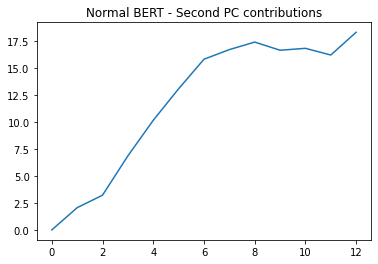

Third PCs [3.5527137e-13, 0.7963947, 1.4201405, 2.8906684, 4.637038, 5.6294146, 7.1394453, 7.769206, 8.311952, 8.001429, 7.9243846, 7.720996, 8.928388]


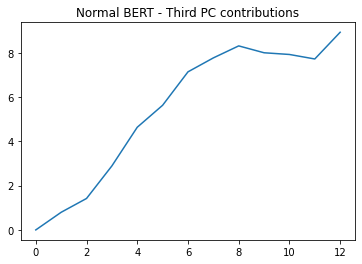

<Figure size 432x288 with 0 Axes>

In [50]:
# average and percentage
ev = [e/count*100 for e in ev]
ev2 = ev

first_pcs = [f[0] for f in ev2]
print('First PCs', first_pcs)
plotVariance(first_pcs, title='Normal BERT - First PC contributions')

second_pcs = [f[1] for f in ev2]
print('Second PCs', second_pcs)
plotVariance(second_pcs, title='Normal BERT - Second PC contributions')

third_pcs = [f[2] for f in ev2]
print('Third PCs', third_pcs)
plotVariance(third_pcs, title='Normal BERT - Third PC contributions')